## Partie 1 : Base de données, Analyse et Préparation


Le Dataset a été décompressé dans le dossier `data/dataset1`.

Par la suite, il faut développer les étapes suivantes :

- Charger les images.
- Penser à redimensionner les images selon le modèle VGG16.
- Splitter les données en données d’apprentissage, validation et test.
- Visualiser les images de la classe Cancer et Sans_cancer.



In [91]:
#!pip install -r requirements.txt

bin   doc     environment.yml  notebooks  README.md	    results
data  docker  LICENSE	       postBuild  requirements.txt  src
     |████████████████████████████████| 1.7 MB 1.4 MB/s eta 0:00:01


In [80]:
import os
import cv2
import pandas as pd
from tqdm import tqdm


In [ ]:

# Resize Image to original VGG16 input size
# from the paper: "During training, the input to our ConvNets 
# is a fixed-size 224 × 224 RGB image"
width = 224
height = 224
dim = (width, height)


def load_images(imagePath):
	# read the image from disk, decode it, convert the data type to
	# floating point, and resize it
	image = tf.io.read_file(imagePath)
	image = tf.image.decode_jpeg(image, channels=3)
	image = tf.image.convert_image_dtype(image, dtype=tf.float32)
	image = tf.image.resize(image, dim)
	# parse the class label from the file path
	label = tf.strings.split(imagePath, os.path.sep)[-2]
	
	# return the image and the label
	return (image, label)


def import_data_label(root_path, dataset):
    labels = pd.read_csv(root_path+os.sep+'labels_' + dataset + '.csv')
    return labels
    

def import_data(root_path, dataset_name):
    labels = import_data_label(root_path, dataset_name)
    data = []
    data_label = []

    for _, image in labels.iterrows():
        file = image.image_name
        label = image.label
        path = root_path+os.sep+dataset_name+os.sep+file
        img = cv2.imread(path)
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        #img, label = load_images(path)
        data.append(img)
        data_label.append(label)

    return (data, data_label)    



In [72]:
drive = None
from google.colab import drive
drive.mount('/content/drive')

In [73]:
if drive is not None :
      root_path = '/content/drive/MyDrive/ISEN/Projets/TP_Maintenance'
else:
  root_path = "."

In [81]:
dataset_name = 'dataset1'

data, data_label= import_data(root_path+os.sep+"data", dataset_name)

print(len(data))
print(len(data_label))

100
100


Les classes ne sont équilibrées (~750 images dans chaque label), on aura donc peut-être besoin d'en augmenter une.


Les targets sont des labels textuels, il faut donc les encoder de façon a travailler sur des nombres.

In [83]:
print("Cardinalité : ", len(set(data_label)))

Cardinalité :  2


Notre dataset a 2 classes, on peut donc utiliser un LabelBinarizer qui va transformer les classes en 0 ou 1.



In [84]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
data_target = lb.fit_transform(data_label)

print(len(data_target))

100


Séparer les données en données d’apprentissage, validation et test.


In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, data_target, test_size=20/100, random_state=42)

print("Train : ", len(X_train), len(y_train))
print("Test : ", len(X_test), len(y_test))



Train :  80 80
Test :  20 20


Visualiser les images de la classe Avec_cancer et Sans_cancer

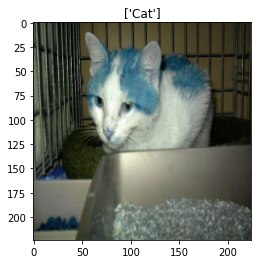

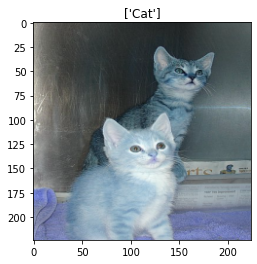

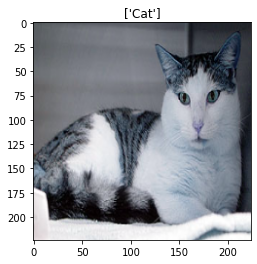

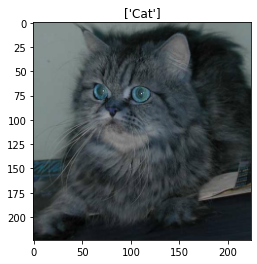

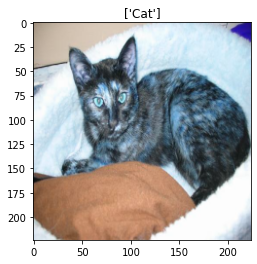

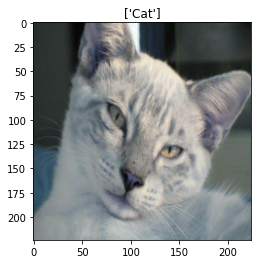

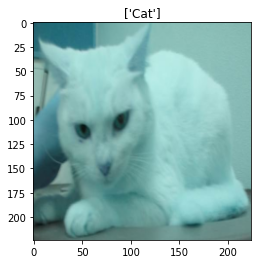

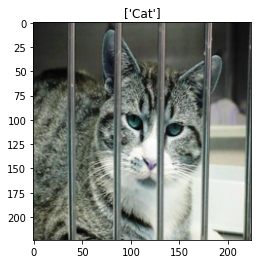

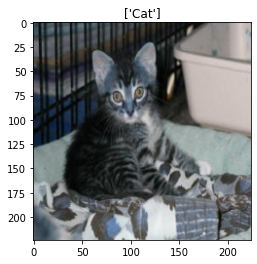

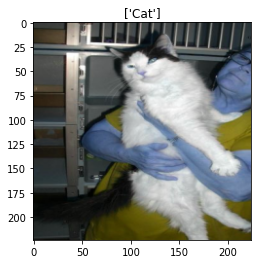

In [86]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
from matplotlib import pyplot as plt

# Afficher 10 images pour vérifier la concordance image / label
for num in range(1, len(X_train), round(len(X_train)/10)):
    image = X_train[num]
    #Show the image with matplotlib
    plt.imshow(image)
    plt.title(lb.inverse_transform(y_train[num]))
    plt.show()



## Partie 2 : Architecture CNN sur Tensorflow


Cette deuxième partie est réservée pour développer le modèle CNN sur tensorflow, et lancer par la suite l’apprentissage de CNN.


### Data Augmentation

Au début, il faut préparer et appliquer la Data Augmentation sur les données d’apprentissage.

In [ ]:
# Data augmentation with tf.data and TensorFlow
from keras import Sequential
from keras import layers as preprocessing
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom


In [ ]:
trainAug = Sequential([
	preprocessing.Rescaling(scale=1.0 / 255),
	preprocessing.RandomFlip("horizontal_and_vertical"),
	preprocessing.RandomZoom(
		height_factor=(-0.05, -0.15),
		width_factor=(-0.05, -0.15)),
	preprocessing.RandomRotation(0.3)
])

In [ ]:
from tensorflow.data import Dataset, AUTOTUNE

BATCH_SIZE = 10

trainDS = Dataset.from_tensor_slices((X_train, y_train))
trainDS = (
	trainDS
	.shuffle(BATCH_SIZE * 100)
	.batch(BATCH_SIZE)
	.map(lambda x, y: (trainAug(x), y),
		 num_parallel_calls=AUTOTUNE)
	.prefetch(AUTOTUNE)
)

Modifiaction à la main


In [ ]:
def augment_using_ops(images, labels):
	images = tf.image.random_flip_left_right(images)
	images = tf.image.random_flip_up_down(images)
	images = tf.image.rot90(images)
	return (images, labels)

#ds = Dataset.from_tensor_slices(imagePaths)
#ds = (ds
#	.shuffle(len(imagePaths), seed=42)
#	.map(load_images, num_parallel_calls=AUTOTUNE)
#	.cache()
#	.batch(BATCH_SIZE)
#	.map(augment_using_ops, num_parallel_calls=AUTOTUNE)
#	.prefetch(AUTOTUNE)
#)


Import des bibliothèques


In [ ]:
import numpy as np
import keras
from keras.layers import Dense, Flatten
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.losses import BinaryCrossentropy
import tensorflow as tf


VGG16 complet


Charger modèle VGG16


In [ ]:

model_VGG_base = VGG16()
model_VGG_base.summary()

tf.keras.utils.plot_model(model_VGG_base)



Configurer le modèle VGG16



Ici, nous ne configurons rien, puis que nous utilisons le modèle par défaut. Note : nous aurons plus de 1000 sorties, et utilisrons que les 2 premières.



Compilation


In [ ]:
model_VGG_base.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model_VGG_base)

dot_img_file = '/tmp/model_VGG_base.png'
tf.keras.utils.plot_model(model_VGG_base, to_file=dot_img_file, show_shapes=True)

Checkpoint



Appeler le ModelCheckpoint pour sauvgarder le meilleurs modèle durant l’apprentissage (from keras.callbacks import ModelCheckpoint)


In [ ]:
from keras.callbacks import ModelCheckpoint

# construct the callback to save only the *best* model to disk
# based on the validation loss
# monitor="val_loss",
# mode="min",
# verbose=1

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


Apprentissage


Lancer un apprentissage en utilisant les données d’apprentissage et les données de validation avec un historique.

In [ ]:
# Normatlisation des images 
from tensorflow import stack

X_train_stacked = stack(X_train)
y_train_stacked = stack(y_train)
X_test_stacked = stack(X_test)
y_test_stacked = stack(y_test)

history = model_VGG_base.fit(X_train_stacked, y_train_stacked, 
                    validation_data=(X_test_stacked, y_test_stacked),
                    epochs=10,
                    callbacks=[model_checkpoint_callback],
                    )


In [ ]:
tf.keras.utils.plot_model(model_VGG_base)


évaluaiton



Tracé des courbes d’accuracy et d’erreur de train et validation.



Accuracy


In [ ]:

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')
plt.title("Accuracy value by epoch")
plt.show()


Loss


In [ ]:

plt.plot(history.history['val_loss'], label = "val_loss")
plt.plot(history.history['loss'], label = "loss")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.ylim([0, 11])
plt.legend(loc = "upper right")
plt.title("Loss value by epoch")
plt.show()


Matrice de confusion

Calculer l’accuracy et la matrice de confusion sur les données de test.

In [ ]:

test_loss, test_acc = model_VGG_base.evaluate(X_test, y_test, verbose=2)
print(test_acc, test_loss)


In [ ]:

# importing the library
import tensorflow as tf

y_prob = model_VGG_base.predict(X_test_stacked)
y_pred = y_prob.argmax(axis=-1)

# Initializing the input tensor
labels = y_pred
predictions = y_test_stacked
weights = None
 
# Printing the input tensor
#print('labels: ', labels)
#print('Predictions: ', predictions)
#print('Weights: ', weights)
 
# Evaluating confusion matrix
confusion_matrix = tf.math.confusion_matrix(labels, predictions, weights=weights)
confusion_matrix


In [ ]:

import seaborn as sns

fig, ax = plt.subplots(figsize=(24,12))
sns.heatmap(confusion_matrix, annot=True, linewidths=.5, fmt='.1g', cmap='coolwarm')
plt.title("Matrice de confusion")
plt.show()

 



Sauvegarde du modèle


In [ ]:

model_VGG16_base.save(root_path+os.sep+'model_VGG16_base-Romain')



 

VGG16 : dernière couche



Charger modèle VGG16


In [ ]:

# Modèle VGG16
model_base = VGG16(weights='imagenet', include_top=False, input_shape = dim+(3,)) 

model_base.summary()
tf.keras.utils.plot_model(model_base)




Configurer le modèle VGG16



Ici on va redéfinir uniquement la dernière couche du modèle VGG16 : on va donc geler toutes les autres.


In [ ]:
# Freezer toutes les couches du du modèle VGG16
for layer in model_base.layers: 
    layer.trainable = False

model_base.summary()
tf.keras.utils.plot_model(model_base)

Défintion de la couche de sortie


La couche de sortie est constituée d'un softmax car nous avons 2 catégories possibles en sortie.


In [ ]:
#model = Sequential()
#model.add(model_base) # Ajout du modèle VGG16
#model.add(Flatten()) 
#model.add(Dense(128,activation='relu', name='dense_1'))  # TODO : sigmoid
#model.add(Dense(2, activation='softmax', name='dense_2-sortie'))

#tf.keras.utils.plot_model(model)

In [ ]:
from keras.layers.advanced_activations import Softmax

input_shape=dim+(3,)
Nbr_Class = 2
Act = "softmax"
CNN1 = tf.keras.applications.VGG16(include_top=False,input_shape=input_shape)
for layer in CNN1.layers:
    layer.trainable = True
fl = Flatten(name='flatten')(CNN1.output)
model = Dense(128, activation='relu')(fl)
model = Dense(Nbr_Class, activation=Act)(model)
model = Model(inputs=CNN1.input, outputs=model, name='VGG16')

tf.keras.utils.plot_model(model)

Compilation

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
tf.keras.utils.plot_model(model)

dot_img_file = '/tmp/model_out.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

Checkpoint



Appeler le ModelCheckpoint pour sauvgarder le meilleurs modèle durant l’apprentissage (from keras.callbacks import ModelCheckpoint)


In [ ]:

from keras.callbacks import ModelCheckpoint

# construct the callback to save only the *best* model to disk
# based on the validation loss
# monitor="val_loss",
# mode="min",
# verbose=1

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


Apprentissage


Lancer un apprentissage en utilisant les données d’apprentissage et les données de validation avec un historique.


In [ ]:
if X_train_stacked is None :
    
  from tensorflow import stack

  X_train_stacked = stack(X_train)
  y_train_stacked = stack(y_train)
  X_test_stacked = stack(X_test)
  y_test_stacked = stack(y_test)


In [ ]:

history = model.fit(X_train_stacked, y_train_stacked, 
                    validation_data=(X_test_stacked, y_test_stacked),
                    epochs=10,
                    callbacks=[model_checkpoint_callback],
                    )



In [ ]:
tf.keras.utils.plot_model(model)

évaluaiton



Tracé des courbes d’accuracy et d’erreur de train et validation.



Accuracy


In [ ]:

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')
plt.title("Accuracy value by epoch")
plt.show()



Loss

In [ ]:

plt.plot(history.history['val_loss'], label = "val_loss")
plt.plot(history.history['loss'], label = "loss")
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.ylim([0, 11])
plt.legend(loc = "upper right")
plt.title("Loss value by epoch")
plt.show()



In [ ]:
Matrice de confusion

In [ ]:

Calcul de l’accuracy et la matrice de confusion sur les données de test.

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc, test_loss)

In [ ]:
# importing the library
import tensorflow as tf

y_prob = model.predict(X_test_stacked)
y_pred = y_prob.argmax(axis=-1)

# Initializing the input tensor
labels = y_pred
predictions = y_test_stacked
weights = None
 
# Printing the input tensor
#print('labels: ', labels)
#print('Predictions: ', predictions)
#print('Weights: ', weights)
 
# Evaluating confusion matrix
confusion_matrix = tf.math.confusion_matrix(labels, predictions, weights=weights)
confusion_matrix

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(24,12))
sns.heatmap(confusion_matrix, annot=True, linewidths=.5, fmt='.1g', cmap='coolwarm')
plt.title("Matrice de confusion")
plt.show()

Sauvegarde du modèle

In [ ]:
model.save(root_path+os.sep+'model_VGG16_out-Romain')